In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder,StandardScaler
from sklearn.ensemble import RandomForestClassifier

from sklearn.metrics import accuracy_score,confusion_matrix,f1_score,recall_score,precision_score
from shapely.geometry import Point
import geopandas as gpd
from geopandas import GeoDataFrame
import geodatasets
import scipy.stats as stats
import warnings
warnings.filterwarnings('ignore')

In [2]:
data_train=pd.read_csv("fraudTrain.csv")
data_test=pd.read_csv("fraudTest.csv")

In [3]:
full_data=pd.concat([data_train, data_test])

In [4]:
full_data.head()

,Unnamed: 0,trans_date_trans_time,cc_num,merchant,category,amt,first,last,gender,street,...,lat,long,city_pop,job,dob,trans_num,unix_time,merch_lat,merch_long,is_fraud
0,0,2019-01-01 00:00:18,2703186189652095,"fraud_Rippin, Kub and Mann",misc_net,4.97,Jennifer,Banks,F,561 Perry Cove,...,36.0788,-81.1781,3495,"Psychologist, counselling",1988-03-09,0b242abb623afc578575680df30655b9,1325376018,36.011293,-82.048315,0
1,1,2019-01-01 00:00:44,630423337322,"fraud_Heller, Gutmann and Zieme",grocery_pos,107.23,Stephanie,Gill,F,43039 Riley Greens Suite 393,...,48.8878,-118.2105,149,Special educational needs teacher,1978-06-21,1f76529f8574734946361c461b024d99,1325376044,49.159047,-118.186462,0
2,2,2019-01-01 00:00:51,38859492057661,fraud_Lind-Buckridge,entertainment,220.11,Edward,Sanchez,M,594 White Dale Suite 530,...,42.1808,-112.2620,4154,Nature conservation officer,1962-01-19,a1a22d70485983eac12b5b88dad1cf95,1325376051,43.150704,-112.154481,0
3,3,2019-01-01 00:01:16,3534093764340240,"fraud_Kutch, Hermiston and Farrell",gas_transport,45.00,Jeremy,White,M,9443 Cynthia Court Apt. 038,...,46.2306,-112.1138,1939,Patent attorney,1967-01-12,6b849c168bdad6f867558c3793159a81,1325376076,47.034331,-112.561071,0
4,4,2019-01-01 00:03:06,375534208663984,fraud_Keeling-Crist,misc_pos,41.96,Tyler,Garcia,M,408 Bradley Rest,...,38.4207,-79.4629,99,Dance movement psychotherapist,1986-03-28,a41d7549acf90789359a9aa5346dcb46,1325376186,38.674999,-78.632459,0


In [5]:
print(full_data.dtypes)

Unnamed: 0                 int64
trans_date_trans_time     object
cc_num                     int64
merchant                  object
category                  object
amt                      float64
first                     object
last                      object
gender                    object
street                    object
city                      object
state                     object
zip                        int64
lat                      float64
long                     float64
city_pop                   int64
job                       object
dob                       object
trans_num                 object
unix_time                  int64
merch_lat                float64
merch_long               float64
is_fraud                   int64
dtype: object


In [6]:

sampled_df = full_data.sample(frac=0.1) 

print(sampled_df.columns)


Index(['Unnamed: 0', 'trans_date_trans_time', 'cc_num', 'merchant', 'category',
       'amt', 'first', 'last', 'gender', 'street', 'city', 'state', 'zip',
       'lat', 'long', 'city_pop', 'job', 'dob', 'trans_num', 'unix_time',
       'merch_lat', 'merch_long', 'is_fraud'],
      dtype='object')


In [7]:
full_data.drop(columns = [full_data.columns[0], full_data.columns[2], full_data.columns[6], full_data.columns[7], full_data.columns[9]], inplace=True)

In [8]:
full_data.head(2)

,trans_date_trans_time,merchant,category,amt,gender,city,state,zip,lat,long,city_pop,job,dob,trans_num,unix_time,merch_lat,merch_long,is_fraud
0,2019-01-01 00:00:18,"fraud_Rippin, Kub and Mann",misc_net,4.97,F,Moravian Falls,NC,28654,36.0788,-81.1781,3495,"Psychologist, counselling",1988-03-09,0b242abb623afc578575680df30655b9,1325376018,36.011293,-82.048315,0
1,2019-01-01 00:00:44,"fraud_Heller, Gutmann and Zieme",grocery_pos,107.23,F,Orient,WA,99160,48.8878,-118.2105,149,Special educational needs teacher,1978-06-21,1f76529f8574734946361c461b024d99,1325376044,49.159047,-118.186462,0


In [9]:
from math import radians, sin, cos, sqrt, atan2

def haversine_distance(lat1, lon1, lat2, lon2):
    R = 6371  # Radius of Earth in kilometers
    lat1_rad, lon1_rad = radians(lat1), radians(lon1)
    lat2_rad, lon2_rad = radians(lat2), radians(lon2)
    dlat = lat2_rad - lat1_rad
    dlon = lon2_rad - lon1_rad
    a = sin(dlat / 2)**2 + cos(lat1_rad) * cos(lat2_rad) * sin(dlon / 2)**2
    c = 2 * atan2(sqrt(a), sqrt(1 - a))
    return R * c
full_data["distance"] = full_data.apply(lambda row: haversine_distance(row['lat'], row['long'], row['merch_lat'], row['merch_long']), axis=1)

In [10]:
full_data["dob"] = pd.to_datetime(full_data["dob"])
# Define a function to calculate age
from datetime import datetime
def calculate_age(dob):
    today = datetime.today()
    age = today.year - dob.year
    if (today.month, today.day) < (dob.month, dob.day):
        age -= 1
    return age

In [11]:
full_data['age'] = full_data['dob'].apply(calculate_age)
full_data.drop(columns = ["dob"], inplace = True)
full_data.sample(2)

,trans_date_trans_time,merchant,category,amt,gender,city,state,zip,lat,long,city_pop,job,trans_num,unix_time,merch_lat,merch_long,is_fraud,distance,age
885798,2019-12-23 06:05:08,fraud_Berge LLC,gas_transport,65.50,F,Blooming Grove,TX,76626,32.0758,-96.7010,1563,Financial adviser,5d735848115c2db375e8e884efdb2956,1356242708,33.064721,-96.813491,0,110.467067,46
885591,2019-12-23 05:02:21,fraud_Erdman-Kertzmann,gas_transport,38.26,M,Kent,OR,97033,45.0838,-120.6649,60,Museum education officer,adad54c524783a050b93d06fb21465ba,1356238941,45.409371,-119.932230,0,67.827463,82


In [12]:
full_data["trans_date_trans_time"] = pd.to_datetime(full_data["trans_date_trans_time"])
full_data["is_weekend"] = full_data["trans_date_trans_time"].dt.day_name().apply(lambda x : int((x == "Friday") | (x == "Sunday") | (x == "saturday")))
def day_period(x):
    if x >=0 and x < 6: return "Night"
    elif x>= 6 and x <= 12: return "Morning"
    elif x> 12 and x <= 15: return "Afternoon"
    elif x> 15 and x <= 20: return "Evening"
    elif x> 20 and x <= 24: return "Night"
full_data["day_period"] = full_data["trans_date_trans_time"].dt.hour.apply(day_period)
full_data["trans_month"] = full_data["trans_date_trans_time"].dt.month_name()

full_data.drop(columns = ["trans_date_trans_time"], inplace = True)
full_data.sample(2)

,merchant,category,amt,gender,city,state,zip,lat,long,city_pop,...,trans_num,unix_time,merch_lat,merch_long,is_fraud,distance,age,is_weekend,day_period,trans_month
173967,fraud_Jast Ltd,shopping_net,4.65,M,Comfrey,MN,56019,44.1111,-94.9134,914,...,5065b4c57f690aeebc3ea82dc68ebcbe,1333260353,44.847299,-94.036837,0,107.412769,80,0,Morning,April
91556,fraud_Streich Ltd,home,72.70,F,Creola,OH,45622,39.3543,-82.5030,321,...,4317915a54ddb0f70756437ed8293ff8,1374528859,39.184324,-83.234195,0,65.720952,45,0,Night,July


In [13]:
numerical = ["amt", "city_pop", "distance", "age"]
categorical = ["category","gender","is_weekend","trans_month","day_period"]
categorical, numerical

(['category', 'gender', 'is_weekend', 'trans_month', 'day_period'],
 ['amt', 'city_pop', 'distance', 'age'])

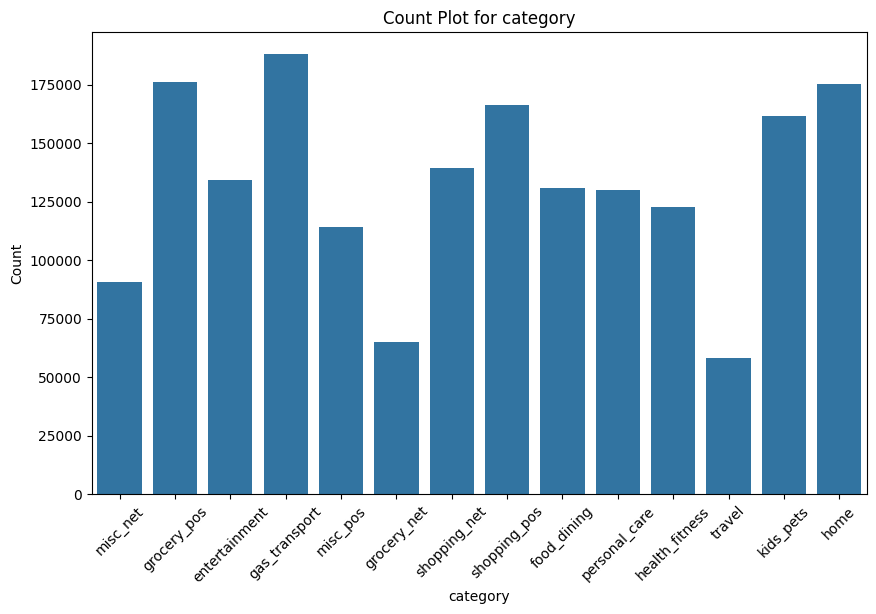

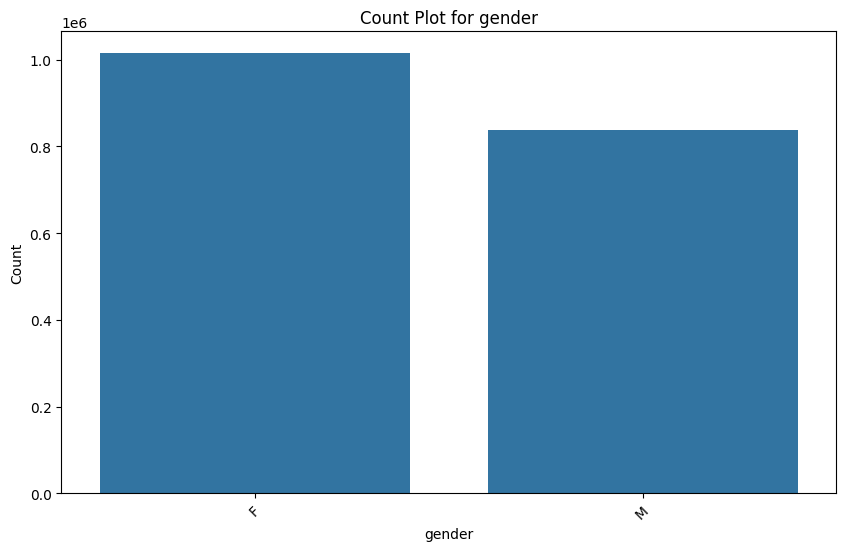

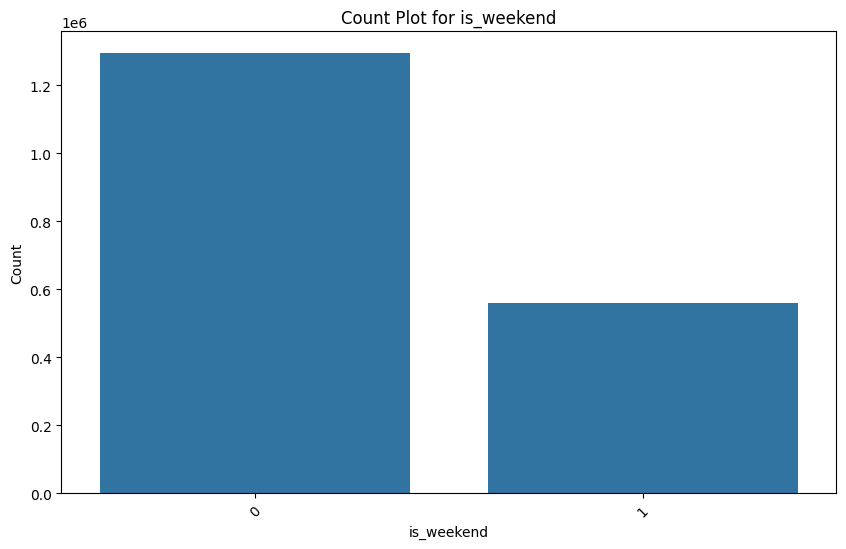

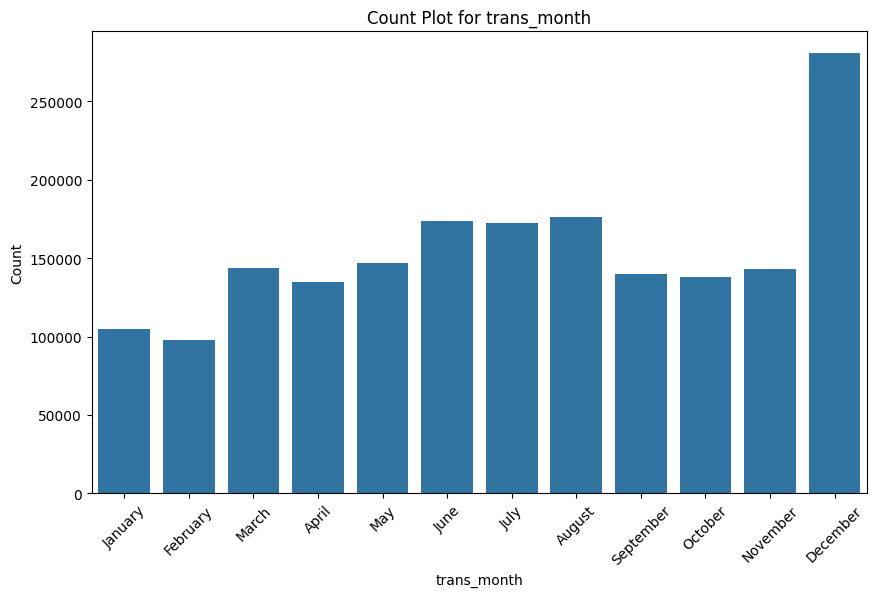

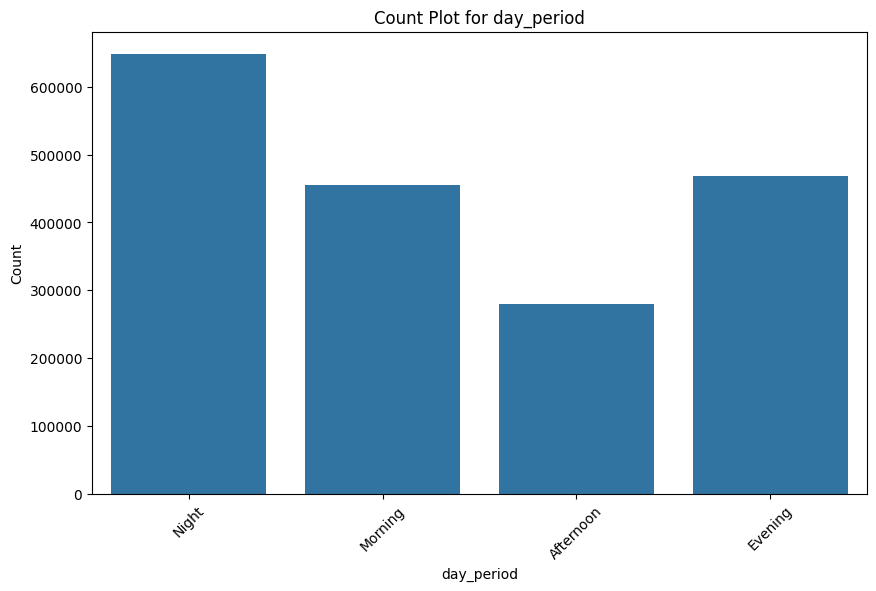

In [14]:
for column in categorical:
    plt.figure(figsize=(10, 6))  # Create a new figure for each plot
    sns.countplot(x=full_data[column])
    plt.title(f'Count Plot for {column}')  # Set the title for each plot
    plt.xlabel(column)  # Set the x-label
    plt.ylabel('Count')  # Set the y-label
    plt.xticks(rotation=45)  # Rotate x-ticks if necessary for better readability
    plt.show()  # Show the plot

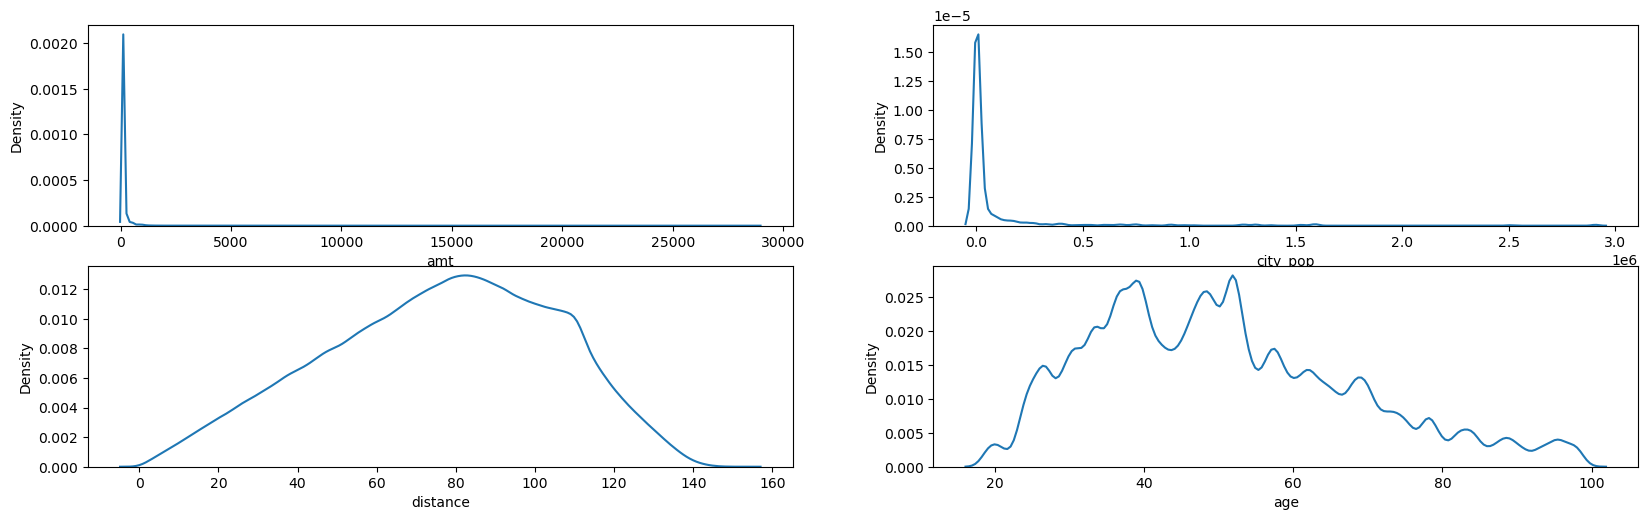

In [20]:
plt.figure(figsize = (20, 12))
cnt = 0
for column in numerical:
    cnt += 1
    plt.subplot(4, 2, cnt)
    sns.kdeplot(x = full_data[column])

In [21]:
for col in numerical:
    print(f"col = {col}\tskewness = {full_data[col].skew()}")

col = amt	skewness = 40.81280917629574
col = city_pop	skewness = 5.590804561529247
col = distance	skewness = -0.235677392216978
col = age	skewness = 0.6129388733956032


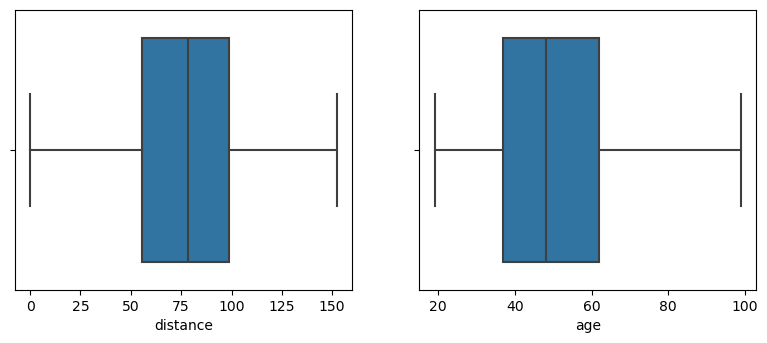

In [22]:
plt.figure(figsize = (20, 8))
cnt = 0
for column in ["distance","age"]:
    cnt += 1
    plt.subplot(2, 4, cnt)
    sns.boxplot(x = full_data[column])

<Axes: >

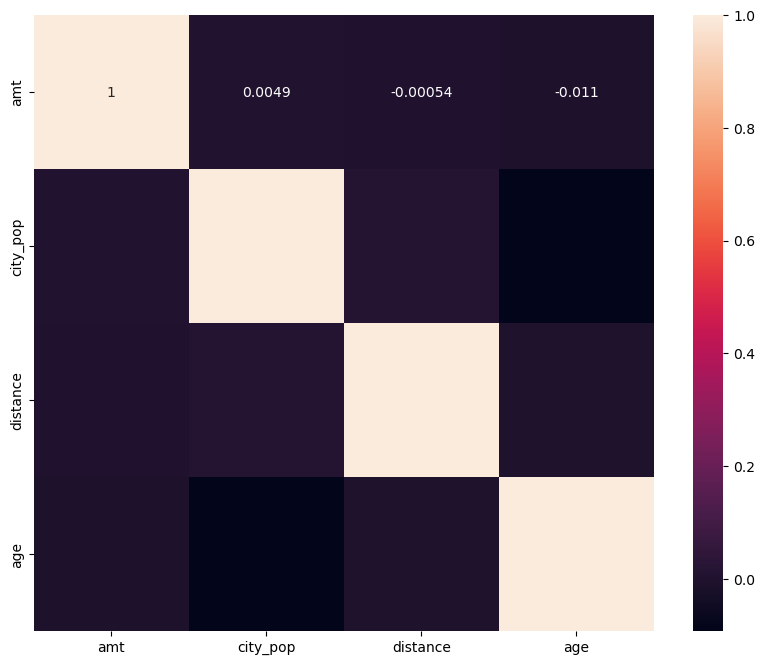

In [23]:
plt.figure(figsize = (10,8))
sns.heatmap(data = full_data[numerical].corr(), annot = True)

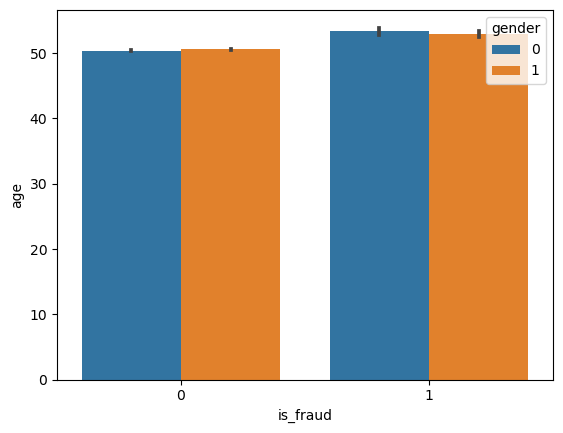

In [31]:
import seaborn as sns
import matplotlib.pyplot as plt

# Ensure 'gender' is treated as a categorical variable
full_data["gender"] = full_data["gender"].astype(str)

# Create the barplot
sns.barplot(y=full_data["age"], x=full_data["is_fraud"], hue=full_data["gender"])

# Display the plot
plt.show()


In [32]:
# Step 1: Calculate fraud percentages for each merchant
merchant_groups = full_data.groupby('merchant')
fraud_percentage_dict = {}

for merchant, group in merchant_groups:
    total_trans = group.shape[0]
    total_fraud_trans = group[group["is_fraud"] == 1].shape[0]
    fraud_percentage_dict[merchant] = (total_fraud_trans / total_trans) * 100

# Step 2: Map the calculated percentages back to the DataFrame
full_data["fraud_merchant_pct"] = full_data["merchant"].map(fraud_percentage_dict)

In [33]:
# Step 1: Rank merchants based on their fraud percentages
# Sort fraud_percentage_dict by fraud percentage
sorted_fraud_percentage = sorted(fraud_percentage_dict.items(), key=lambda x: x[1])

# Create a dictionary for ordinal encoding
merchant_ordinal_dict = {merchant: rank + 1 for rank, (merchant, _) in enumerate(sorted_fraud_percentage)}

# Step 2: Map the ordinal encoding back to the DataFrame
full_data["merchant_ordinal"] = full_data["merchant"].map(merchant_ordinal_dict)

<Axes: xlabel='is_fraud', ylabel='fraud_merchant_pct'>

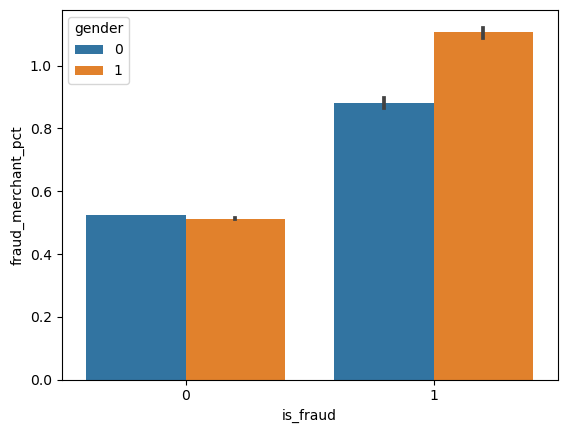

In [34]:
sns.barplot(y = full_data["fraud_merchant_pct"], x=full_data["is_fraud"], hue = full_data["gender"])

<Axes: xlabel='is_weekend', ylabel='amt'>

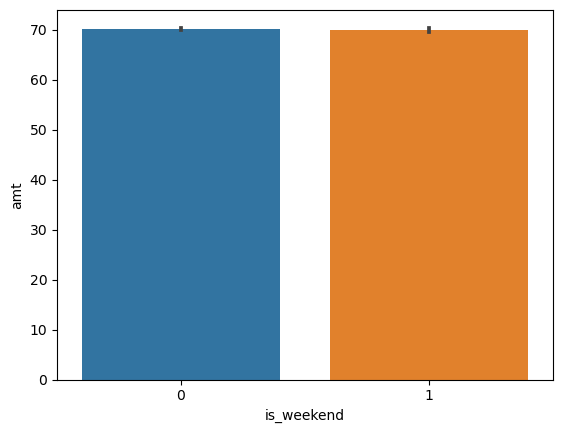

In [35]:
sns.barplot(y = full_data["amt"], x=full_data["is_weekend"])

<Axes: xlabel='trans_month', ylabel='amt'>

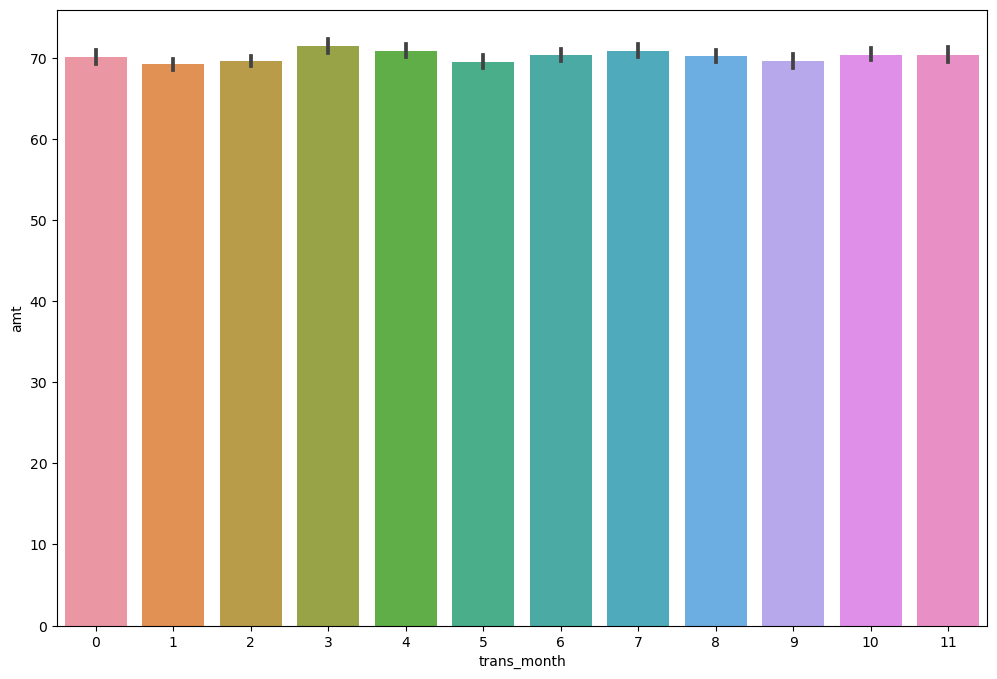

In [36]:
plt.figure(figsize = (12, 8))
sns.barplot(y = full_data["amt"], x=full_data["trans_month"])

<Axes: xlabel='category', ylabel='fraud_merchant_pct'>

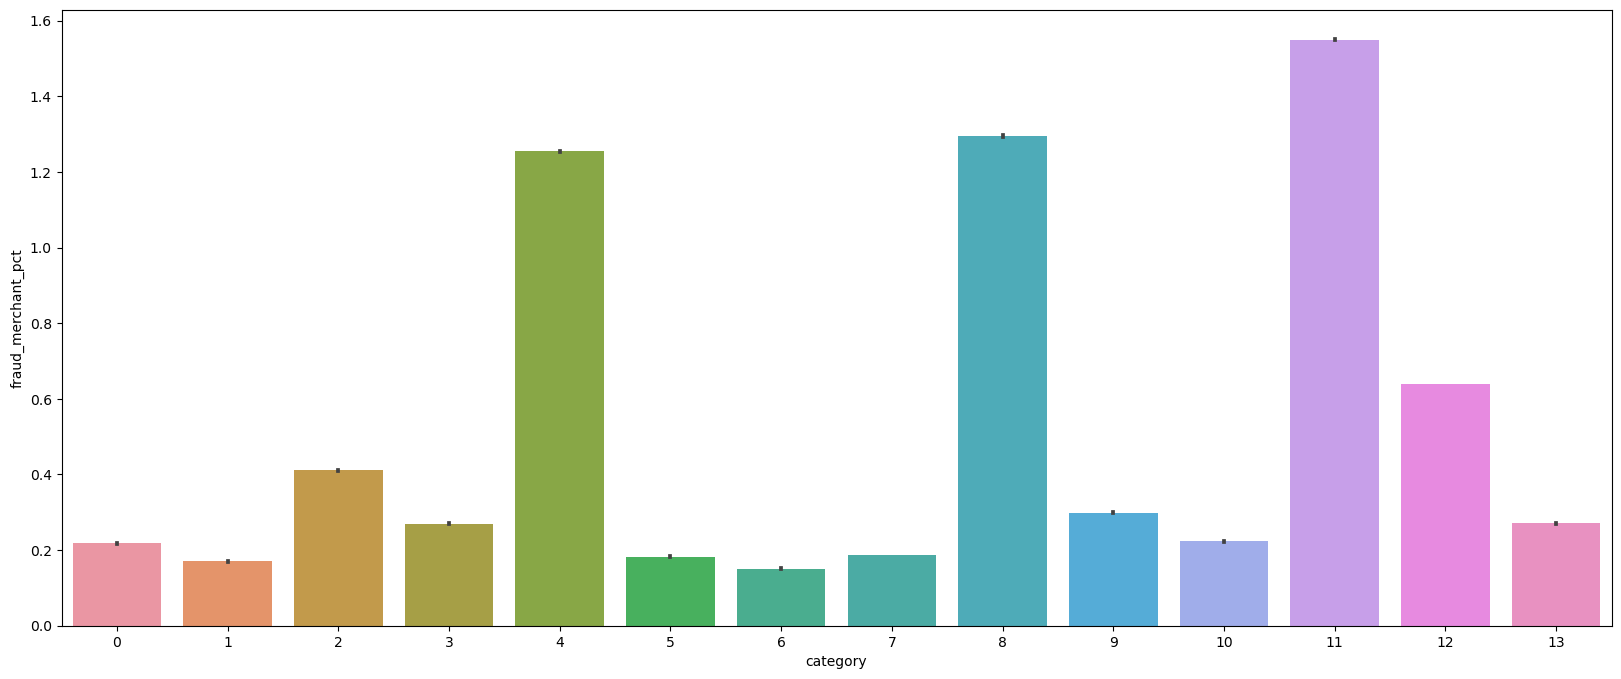

In [37]:
plt.figure(figsize = (20, 8))
sns.barplot(y = full_data["fraud_merchant_pct"], x=full_data["category"])

<Axes: xlabel='day_period', ylabel='amt'>

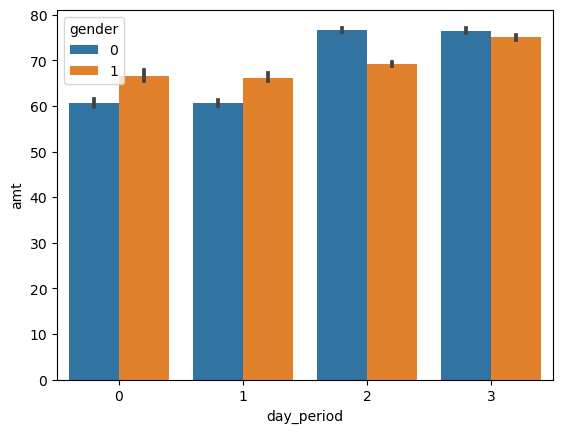

In [38]:
# plt.figure(figsize = (12, 8))
sns.barplot(y = full_data["amt"], x=full_data["day_period"], hue = full_data["gender"])

<Axes: xlabel='is_fraud', ylabel='category'>

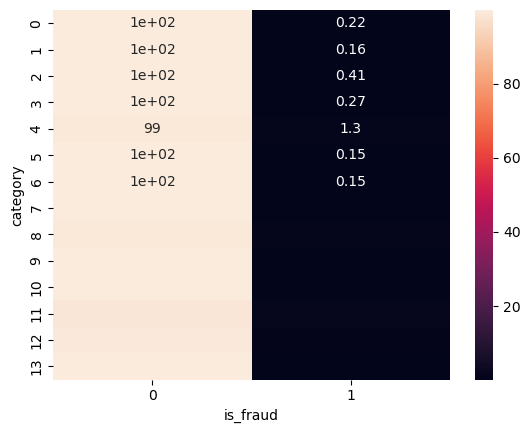

In [39]:
sns.heatmap(data=pd.crosstab(full_data["category"],full_data["is_fraud"], normalize = "index") * 100, annot = True)

<Axes: title={'center': 'Transaction Type Distribution'}, xlabel='category'>

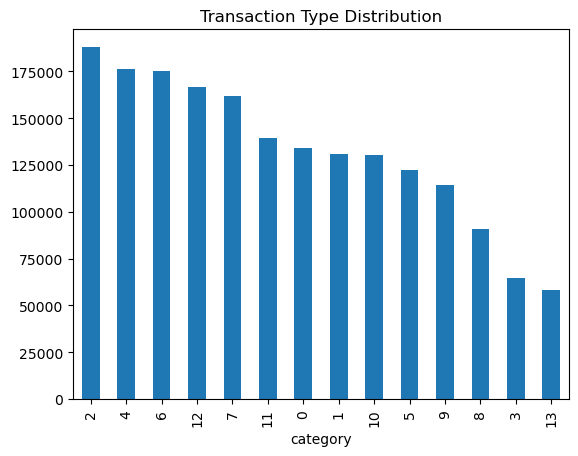

In [40]:
full_data['category'] = full_data['category'].astype('category')

transaction_counts = full_data['category'].value_counts()
transaction_counts.plot(kind='bar', title='Transaction Type Distribution')

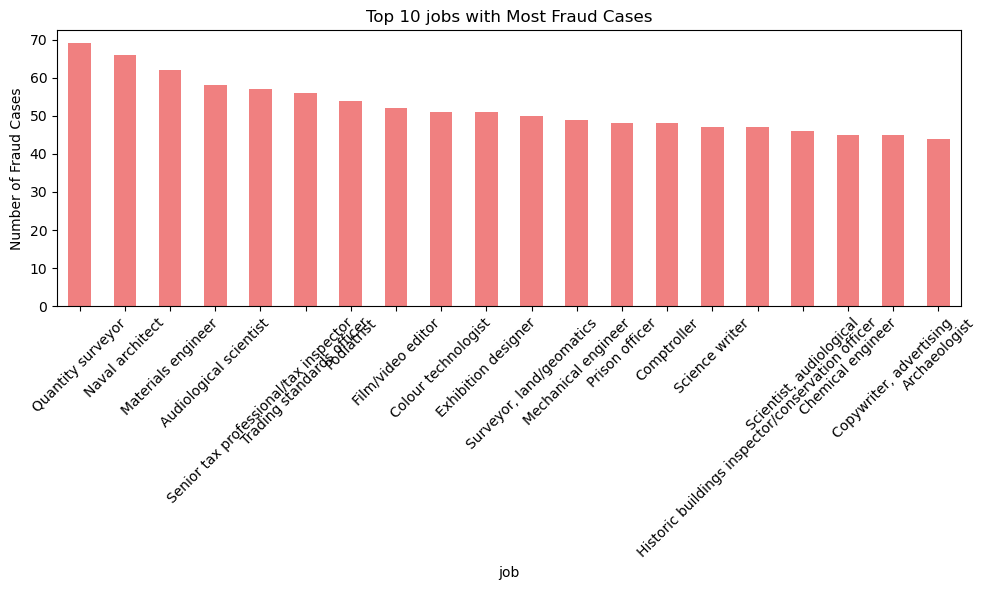

In [41]:
# Filter for fraud cases
fraud_df = full_data[full_data['is_fraud'] == 1]

# Group by street and count the occurrences
top_fraud_streets = fraud_df['job'].value_counts().head(20)

# Plotting
plt.figure(figsize=(10, 6))
top_fraud_streets.plot(kind='bar', color='lightcoral')
plt.title('Top 10 jobs with Most Fraud Cases')
plt.xlabel('job')
plt.ylabel('Number of Fraud Cases')
plt.xticks(rotation=45)
plt.tight_layout()

# Display the plot
plt.show()


<Axes: xlabel='is_fraud', ylabel='is_weekend'>

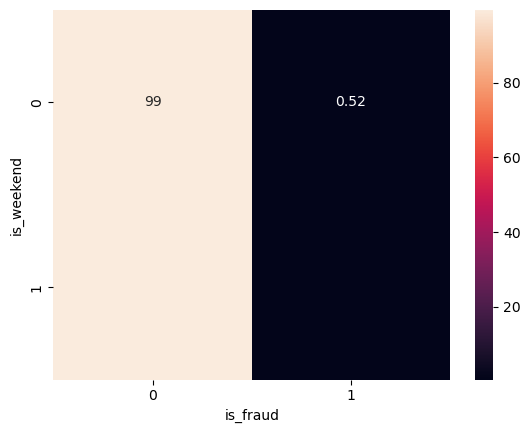

In [43]:
sns.heatmap(data=pd.crosstab(full_data["is_weekend"],full_data["is_fraud"], normalize = "index") * 100, annot = True)

<Axes: xlabel='is_fraud', ylabel='day_period'>

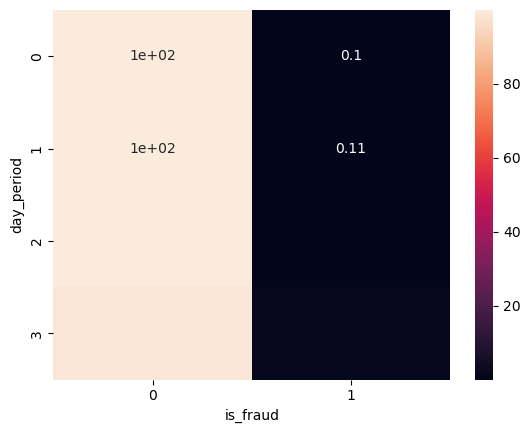

In [44]:
sns.heatmap(data=pd.crosstab(full_data["day_period"],full_data["is_fraud"], normalize = "index") * 100, annot = True)

In [45]:
from imblearn.under_sampling import RandomUnderSampler

# Initialize the sampler
sampler = RandomUnderSampler(random_state=42)

# Separate features and target
X = full_data.drop('is_fraud', axis=1)
y = full_data['is_fraud']

# Perform random undersampling
X_resampled, y_resampled = sampler.fit_resample(X, y)

In [47]:
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix, f1_score, recall_score, precision_score
from imblearn.under_sampling import RandomUnderSampler
import numpy as np

# 1. Encode categorical variables
label_encoder = LabelEncoder()
for col in categorical:
    full_data[col] = label_encoder.fit_transform(full_data[col])

# 2. Define features (X) and target (y)
X = full_data[numerical + categorical]
y = full_data["is_fraud"]

# 3. Perform random undersampling
sampler = RandomUnderSampler(random_state=42)
X_resampled, y_resampled = sampler.fit_resample(X, y)

# 4. Split the resampled data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_resampled, y_resampled, test_size=0.2, random_state=42)

# 5. Scale the numerical features
scaler = StandardScaler()
X_train[numerical] = scaler.fit_transform(X_train[numerical])
X_test[numerical] = scaler.transform(X_test[numerical])

# 6. Train the Linear Regression Model
linear_model = LinearRegression()
linear_model.fit(X_train, y_train)

# 7. Predict
y_pred_lr = linear_model.predict(X_test)

# 8. Apply threshold (convert to binary classification)
y_pred_lr = np.where(y_pred_lr > 0.5, 1, 0)

# 9. Evaluate the Linear Regression Model
print("Linear Regression Model")
print("Accuracy: ", accuracy_score(y_test, y_pred_lr))
print("Confusion Matrix: \n", confusion_matrix(y_test, y_pred_lr))
print("F1 Score: ", f1_score(y_test, y_pred_lr))
print("Recall: ", recall_score(y_test, y_pred_lr))
print("Precision: ", precision_score(y_test, y_pred_lr))


Linear Regression Model
Accuracy:  0.8231028231028231
Confusion Matrix: 
 [[1752  177]
 [ 506 1426]]
F1 Score:  0.8067892503536068
Recall:  0.7380952380952381
Precision:  0.8895820336868372


In [49]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, f1_score, recall_score, precision_score
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from imblearn.under_sampling import RandomUnderSampler

# Assuming `full_data`, `categorical`, and `numerical` have already been defined

# 1. Encode categorical variables
label_encoder = LabelEncoder()
for col in categorical:
    full_data[col] = label_encoder.fit_transform(full_data[col])

# 2. Define features (X) and target (y)
X = full_data[numerical + categorical]
y = full_data["is_fraud"]

# 3. Perform random undersampling
sampler = RandomUnderSampler(random_state=42)
X_resampled, y_resampled = sampler.fit_resample(X, y)

# 4. Split the resampled data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_resampled, y_resampled, test_size=0.2, random_state=42)

# 5. Scale the numerical features
scaler = StandardScaler()
X_train[numerical] = scaler.fit_transform(X_train[numerical])
X_test[numerical] = scaler.transform(X_test[numerical])

# 6. Train the Decision Tree Classifier on the resampled data
dt_model = DecisionTreeClassifier(random_state=42)
dt_model.fit(X_train, y_train)

# 7. Predict on the test data
y_pred_dt = dt_model.predict(X_test)

# 8. Evaluate the Decision Tree Model
print("Decision Tree Model")
print("Accuracy: ", accuracy_score(y_test, y_pred_dt))
print("Confusion Matrix: \n", confusion_matrix(y_test, y_pred_dt))
print("F1 Score: ", f1_score(y_test, y_pred_dt))
print("Recall: ", recall_score(y_test, y_pred_dt))
print("Precision: ", precision_score(y_test, y_pred_dt))
print("\n")


Decision Tree Model
Accuracy:  0.9624449624449625
Confusion Matrix: 
 [[1852   77]
 [  68 1864]]
F1 Score:  0.962561321972631
Recall:  0.9648033126293996
Precision:  0.9603297269448737




In [50]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, f1_score, recall_score, precision_score
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from imblearn.under_sampling import RandomUnderSampler

# Assuming `full_data`, `categorical`, and `numerical` have already been defined

# 1. Encode categorical variables
label_encoder = LabelEncoder()
for col in categorical:
    full_data[col] = label_encoder.fit_transform(full_data[col])

# 2. Define features (X) and target (y)
X = full_data[numerical + categorical]
y = full_data["is_fraud"]

# 3. Perform random undersampling
sampler = RandomUnderSampler(random_state=42)
X_resampled, y_resampled = sampler.fit_resample(X, y)

# 4. Split the resampled data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_resampled, y_resampled, test_size=0.2, random_state=42)

# 5. Scale the numerical features
scaler = StandardScaler()
X_train[numerical] = scaler.fit_transform(X_train[numerical])
X_test[numerical] = scaler.transform(X_test[numerical])

# 6. Initialize and train Random Forest model on the resampled data
rf_model = RandomForestClassifier(random_state=42, n_estimators=100)
rf_model.fit(X_train, y_train)

# 7. Predict on the test data
y_pred_rf = rf_model.predict(X_test)

# 8. Evaluate the Random Forest model
print("Random Forest Model")
print("Accuracy: ", accuracy_score(y_test, y_pred_rf))
print("Confusion Matrix: \n", confusion_matrix(y_test, y_pred_rf))
print("F1 Score: ", f1_score(y_test, y_pred_rf))
print("Recall: ", recall_score(y_test, y_pred_rf))
print("Precision: ", precision_score(y_test, y_pred_rf))


Random Forest Model
Accuracy:  0.970991970991971
Confusion Matrix: 
 [[1883   46]
 [  66 1866]]
F1 Score:  0.9708636836628513
Recall:  0.9658385093167702
Precision:  0.9759414225941423


In [51]:
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score, classification_report
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from imblearn.under_sampling import RandomUnderSampler

# Assuming `full_data`, `categorical`, and `numerical` have already been defined

# 1. Encode categorical variables
label_encoder = LabelEncoder()
for col in categorical:
    full_data[col] = label_encoder.fit_transform(full_data[col])

# 2. Define features (X) and target (y)
X = full_data[numerical + categorical]
y = full_data["is_fraud"]

# 3. Perform random undersampling
sampler = RandomUnderSampler(random_state=42)
X_resampled, y_resampled = sampler.fit_resample(X, y)

# 4. Split the resampled data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_resampled, y_resampled, test_size=0.2, random_state=42)

# 5. Scale the numerical features
scaler = StandardScaler()
X_train[numerical] = scaler.fit_transform(X_train[numerical])
X_test[numerical] = scaler.transform(X_test[numerical])

# 6. Initialize and train XGBoost model on the resampled data
xgb_model = XGBClassifier(use_label_encoder=False, eval_metric='logloss')
xgb_model.fit(X_train, y_train)

# 7. Predict on the test data
y_pred_xg = xgb_model.predict(X_test)

# 8. Evaluate the XGBoost model
print("XG Boost Model")
print("Accuracy: ", accuracy_score(y_test, y_pred_xg))
print("Classification Report:")
print(classification_report(y_test, y_pred_xg))


XG Boost Model
Accuracy:  0.9764309764309764
Classification Report:
              precision    recall  f1-score   support

           0       0.98      0.97      0.98      1929
           1       0.97      0.98      0.98      1932

    accuracy                           0.98      3861
   macro avg       0.98      0.98      0.98      3861
weighted avg       0.98      0.98      0.98      3861



In [54]:
import joblib

# Save the model
joblib.dump(xgb_model, 'xgb_model.pkl')

# Save the scaler (since it's needed for transforming new inputs)
joblib.dump(scaler, 'scaler.pkl')

['scaler.pkl']

In [55]:
!pip install Flask

In [11]:
from flask import Flask, request, jsonify
import joblib
import numpy as np

app = Flask(__name__)

# Load the saved model and scaler
model = joblib.load('xgb_model.pkl')
scaler = joblib.load('scaler.pkl')

# Define the prediction endpoint
@app.route('/predict', methods=['POST'])
def predict():
    data = request.get_json()  # Get JSON data from the POST request
    
    # Extract features (assuming a JSON structure like {'input': [feature1, feature2, ...]})
    features = np.array(data['input']).reshape(1, -1)  # Reshape to fit model input
    
    # Scale the numerical features
    num_numerical_features = len(scaler.mean_)  # Assuming the scaler was fitted on numerical features
    features[:, :num_numerical_features] = scaler.transform(features[:, :num_numerical_features])

    # Make predictions
    prediction = model.predict(features)
    
    return jsonify({'prediction': int(prediction[0])})

if __name__ == '_main_':
    app.run(debug=True)

C:\Users\chavi\Desktop\Anaconda\Lib\site-packages\sklearn\base.py:376: InconsistentVersionWarning: Trying to unpickle estimator StandardScaler from version 1.4.1.post1 when using version 1.4.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(


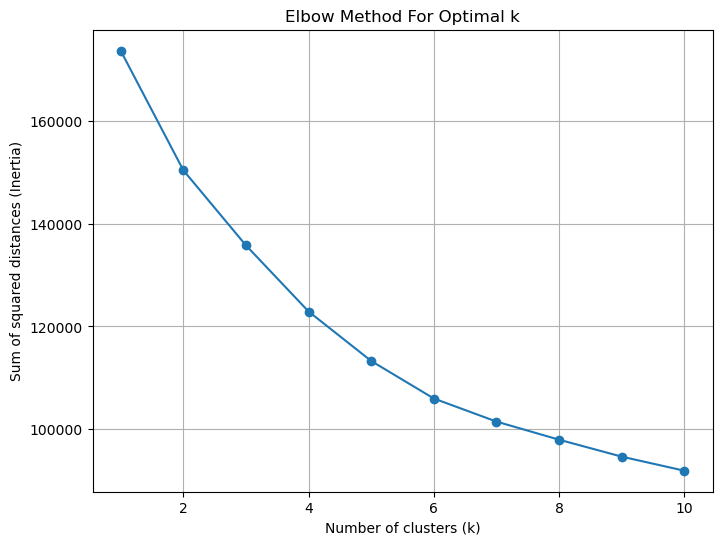

In [53]:
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt

# Assuming X_resampled is already defined from previous steps
# We will scale the resampled data first
scaler = StandardScaler()
data_scaled = scaler.fit_transform(X_resampled)

# Elbow method to determine the optimal number of clusters
sse = []  
k_range = range(1, 11)

# Calculate SSE for different values of k
for k in k_range:
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(data_scaled)
    sse.append(kmeans.inertia_)

# Plot the Elbow Method graph
plt.figure(figsize=(8, 6))
plt.plot(k_range, sse, marker='o')
plt.xlabel('Number of clusters (k)')
plt.ylabel('Sum of squared distances (Inertia)')
plt.title('Elbow Method For Optimal k')
plt.grid(True)
plt.show()


In [ ]:

import numpy as np
import pandas as pd
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn.compose import ColumnTransformer

# Step 1: Data Preprocessing
# Assuming df is your DataFrame, and 'is_fraud' is your target variable

# Define numerical and categorical columns
num_cols = ['amt', 'lat', 'long','age']  # Including new columns
cat_cols = ['merchant', 'day_of_week', 'trans_month','day_period']  # Categorical columns (one-hot encoded)

# Preprocessing pipeline
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), num_cols),  # Standardizing numerical features
        ('cat', OneHotEncoder(), cat_cols)])  # One-hot encoding categorical features

# Preprocess the features
X_processed = preprocessor.fit_transform(full_data.drop(columns=['is_fraud']))

# Target variable
y = full_data['is_fraud']

# Step 2: Reshape the Data for LSTM
# Assuming each user has multiple transactions, we need to group by user or transaction sequence
# For the sake of simplicity, let's assume a sequence length of 10 transactions

sequence_length = 10

def create_sequences(X, y, sequence_length):
    X_seq, y_seq = [], []
    for i in range(len(X) - sequence_length):
        X_seq.append(X[i:i+sequence_length])
        y_seq.append(y[i+sequence_length])
    return np.array(X_seq), np.array(y_seq)

# Create sequences
X_seq, y_seq = create_sequences(X_processed, y, sequence_length)

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X_seq, y_seq, test_size=0.3, stratify=y_seq, random_state=42)

# Step 3: Define the LSTM Model
model = Sequential()

# Add the first LSTM layer with 50 units, return sequences to stack more layers
model.add(LSTM(50, return_sequences=True, input_shape=(X_train.shape[1], X_train.shape[2])))
model.add(Dropout(0.5))  # Dropout layer for regularization

# Add another LSTM layer
model.add(LSTM(50, return_sequences=False))
model.add(Dropout(0.5))

# Add a Dense layer with 1 output (since it's a binary classification)
model.add(Dense(1, activation='sigmoid'))  # Sigmoid for binary output

# Step 4: Compile the Model
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Step 5: Train the Model
history = model.fit(X_train, y_train, epochs=20, batch_size=32, validation_data=(X_test, y_test))

# Step 6: Evaluate the Model
scores = model.evaluate(X_test, y_test)
print(f"Test Accuracy: {scores[1]}")